# 8.1 어텐션의 구조

## 8.1.1 seq2seq의 문제점

seq2seq: Encoder가 시계열 데이터를 인코딩 > Decoder로 전달

Encoder는 Context vector로 변환하기 떄문에 필요한 정보 vector에 다 담기지 못함.

## 8.1.2 Encoder 개선

Encoder출력의 길이를 입력 문장의 길이에 따라 만들어 주는것이 좋음.

-LSTM 계층의 은닉 상태의 '내용': 직전에 입력된 단어에 정보포함多

예) "고양이" 입력시 LSTM계층의 은닉상태는 "고양이"영향&"고양이"성분이 많이 들어간 벡터
>> 해결방안: 시각별 LSTM계층의 은닉 상태 벡터 모두 이용
이로써 입력된 단어와 같은 수의 벡터를 얻으면서 '고정 길이 벡터'제약으로부터 해결

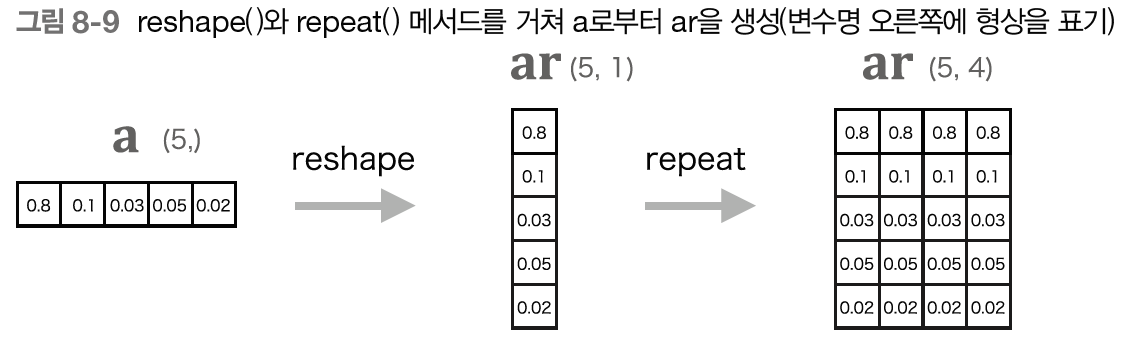

## 8.1.3 Decoder개선

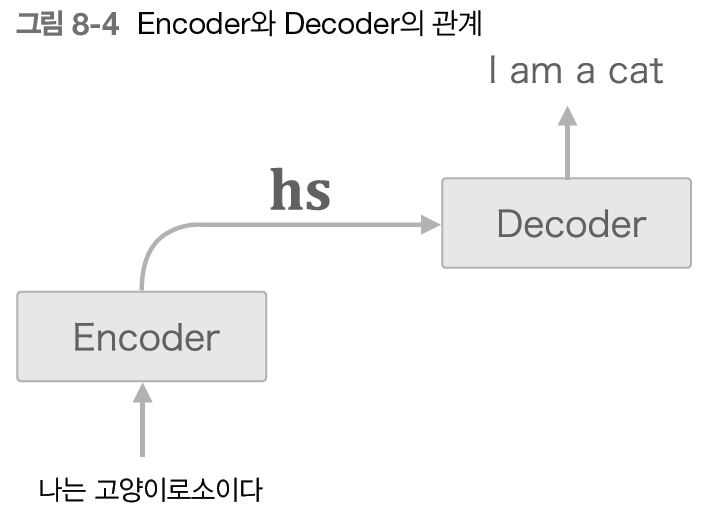

hs를 각 단어에 해당하는 벡터들의 집합이라고 보면
Encoder는 hs로 모아 출력을 하고 Decoder로 전달되어 시계열 변환이 이뤄짐.

같은 단어의 대응 관계를 나타내는 정보를 얼라인먼트(alignment)라고 하는데 지금까지 수작업으로 얼라인먼트를 만들었다면 어텐션 메커니즘을 활용하면 얼라인먼트를 자동으로 만들 수 있다.

예를 들어 한국어를 영어로 번역한다고 가정했을 때 '특정 영어 단어'와 대응 관계가 있는 '특정 한국어 단어' 정보를 골라내는 것이 어텐션의 핵심포인트.

Encoder의 LSTM계층의 '마지막'은닉 상태를 Decoder의 LSTM계층의 '첫'은닉 상태로 설정

어텐션의 구조: 입력과 출력 여러단어 중 서로 관련있는 단어끼리 seq2seq에 학습을 시켜 시계열변환을 수행하는것

**㉠ Decoder의 개선**
단어들의 얼라인먼트를 추출하는것이 우리의 목적 즉 Decoder의 각 스텝에서 출력하고자 하는 단어와 대응 관계인 단어의 벡터를 hs에서 골라 내겠다는것.

문제는 여러 대상으로 부터 몇개를 선택하는 작업은 미분을 할 수 없다.
고로 모든 단어들을 선택을 하고 '가중치'(각 단어의 중요도)가 큰 단어를 선택한다.
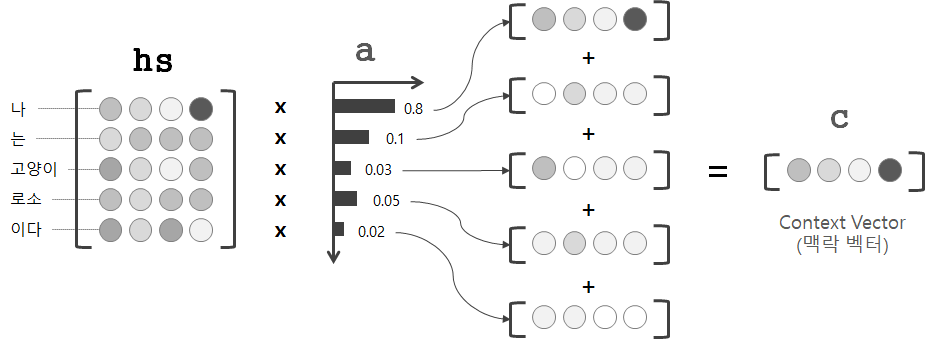

a는 0.0~1.0사이의 스칼라이며 모든 총합은 1이 된다.
a와 hs로부터 가중합을 구하여 원하는 벡터를 얻는다.
이를 '맥락 벡터'라고 하여 c로 표기한다.
> 맥락 벡터 c에 "나"벡터의 성분이 많이 포함되어있어서 "나"벡터를 '선택'하는 작업을 가중합으로 대체하고 있다.

In [1]:
# 시계열 데이터에 대해 어텐션 메커니즘을 구현한 코드
#Encoder가 출력하는 hs와 각 단어의 가중치 a를 작성한 후 가중합을 구하는것을 구현

import numpy as np

T, H = 5, 4  # 시계열 길이(T)를 5, 은닉 상태 벡터의 원소 수(H)를 4로 설정
hs = np.random.randn(T, H)  # (5, 4) 크기의 랜덤 행렬 생성, 인코더의 출력
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])  # 각 시계열 데이터의 가중치 (5,)

# 가중치를 (5, 1) 크기로 변경한 후, H=4번 반복하여 (5, 4) 크기의 가중치 행렬 생성
ar = a.reshape(5, 1).repeat(4, axis=1)
print(ar.shape)  # 출력: (5, 4)

# hs와 ar의 원소별 곱셈 (element-wise multiplication)
t = hs * ar
print(t.shape)  # 출력: (5, 4)

# t의 각 열에 대해 합계를 계산하여 컨텍스트 벡터 c를 생성 (각 열의 합계를 구함)
c = np.sum(t, axis=0)
print(c.shape)  # 출력: (4,)


(5, 4)
(5, 4)
(4,)


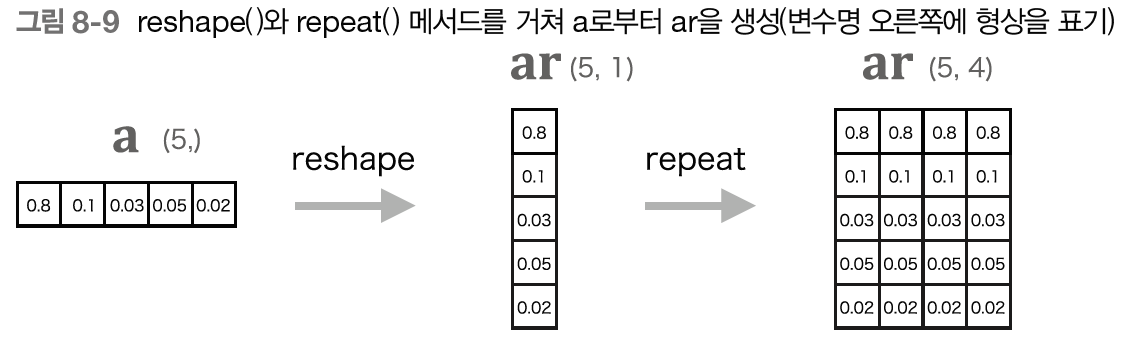

(5,)인 a를 복사하여 reshape를 거쳐 (5,1)형상으로 만들고 네번 반복하여 (5,4)배열 생성

In [2]:
#  N개의 시계열 데이터에 대해 어텐션 메커니즘을 적용하는 코드
import numpy as np

N, T, H = 10, 5, 4  # 배치 크기(N), 시계열 길이(T), 은닉 상태 벡터의 차원(H)
hs = np.random.randn(N, T, H)  # (10, 5, 4) 크기의 랜덤 행렬, 인코더의 출력
a = np.random.randn(N, T)  # (10, 5) 크기의 랜덤 행렬, 각 시계열 데이터의 가중치

# 가중치를 (N, T, 1)로 확장하고 H번 반복하여 (N, T, H) 크기의 가중치 행렬 생성
ar = a.reshape(N, T, 1).repeat(H, axis=2)
# ar = a.reshape(N, T, 1)  # 브로드캐스트를 사용하는 경우

t = hs * ar  # 인코더의 출력에 가중치를 적용하여 각 시계열 데이터의 컨텍스트 벡터를 계산
print(t.shape)  # 출력: (10, 5, 4)

c = np.sum(t, axis=1)  # 각 시계열 데이터에 대해 컨텍스트 벡터의 합을 계산
print(c.shape)  # 출력: (10, 4)


(10, 5, 4)
(10, 4)


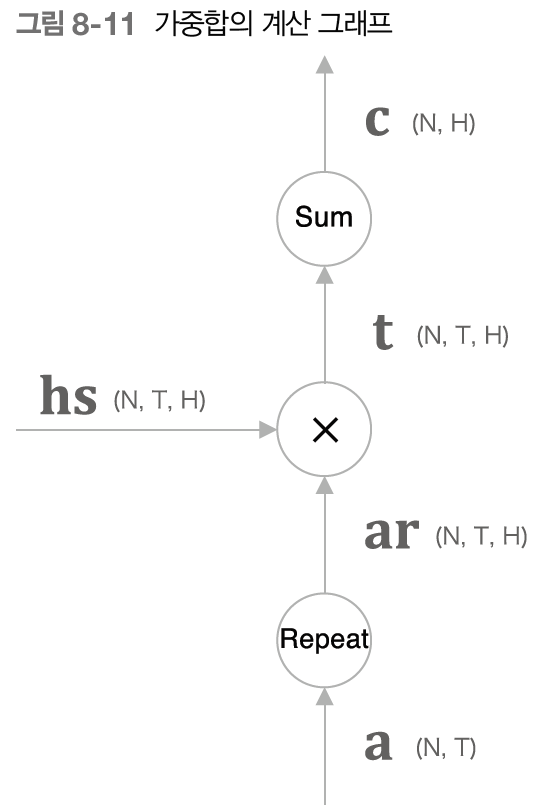

Repeat노드로 a를 복제, 'x'노드로 원소별 곱을 계산 후 Sum노드로 합 구함.

In [3]:
#위 그래프의 역전파를 구현
#'Repeat의 역전파는 Sum'이고 'Sum의 역전파는 Repeat'

import numpy as np

class WeightSum:
    def __init__(self):
        self.params, self.grads = [], [] # 학습하는 매개변수가 없어서 self.paramas=[]
        self.cache = None

    def forward(self, hs, a):
        N, T, H = hs.shape

        ar = a.reshape(N, T, 1).repeat(H, axis=2)  # 가중치를 (N, T, 1)로 reshape 후 H번 반복하여 (N, T, H) 크기의 행렬 생성
        t = hs * ar  # 원소별 곱셈
        c = np.sum(t, axis=1)  # 시계열 길이(T) 차원에 대해 합산하여 각 데이터에 대한 가중 평균 계산

        self.cache = (hs, ar)  # 순전파 계산에 사용된 값 저장
        return c

    def backward(self, dc):
        hs, ar = self.cache  # 순전파 때 계산했던 값 로드
        N, T, H = hs.shape

        dt = dc.reshape(N, 1, H).repeat(T, axis=1)  # Sum 노드의 역전파
        dar = dt * hs  # 원소별 곱셈
        dhs = dt * ar  # 원소별 곱셈
        da = np.sum(dar, axis=2)  # Repeat 노드의 역전파

        return dhs, da

**㉡ Decoder의 개선**

단어의 중요성을 나타내는 가중치: a

가중합을 이용해 맥락 벡터를 얻을 수 있음.

가중치 a를 구하는 방법
1. Decoder의 첫번째 LSTM계층이 은닉 상태 벡터를 출력할 때까지의 처리 알아보기
> 내적으로 두 벡터 h와 hs 내적으로 유사도를 산출.
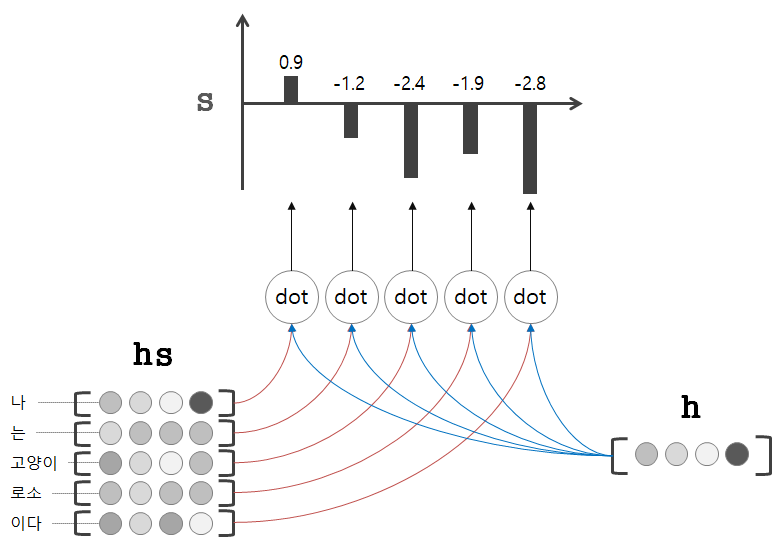

s는 h와 hs의 유사도 결과. 이때의 s는 정규화 전의 값이기에 Softmax 함수를 적용한다.

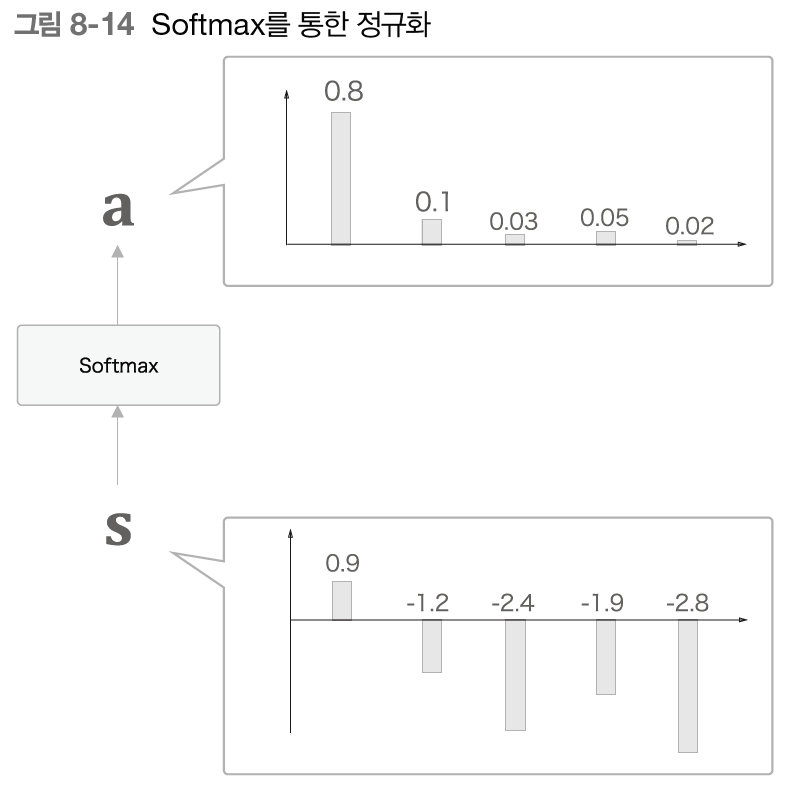

소프트맥스 함수를 이용하면 a의 각 원소는 0.0~1.0사이의 값이 되고 모든 원소의 총합은 1이 된다.

In [4]:
import sys
sys.path.append('..')  # 상위 디렉토리를 파이썬 모듈 검색 경로에 추가

from common.layers import Softmax  # Softmax 레이어 임포트
import numpy as np  # NumPy 임포트

# 시계열 데이터의 크기와 은닉 상태의 크기 설정
N, T, H = 10, 5, 4

# 시계열 데이터의 형상을 가진 랜덤 행렬 생성
hs = np.random.randn(N, T, H)
# 현재 시점의 은닉 상태를 가진 랜덤 행렬 생성
h = np.random.randn(N, H)

# 브로드캐스트를 사용하여 현재 시점의 은닉 상태를 적절한 형상으로 변환
hr = h.reshape(N, 1, H).repeat(T, axis=1)
# hr = h.reshape(N, 1, H)  # 브로드캐스트를 사용하는 경우

# 각 시계열 데이터의 현재 시점의 은닉 상태와의 원소별 곱셈
t = hs * hr
print(t.shape)

# 각 시계열 데이터에 대한 가중 합을 계산하여 (N, T) 형태의 행렬 생성
s = np.sum(t, axis=2)
print(s.shape)

# Softmax 레이어를 이용하여 각 시계열 데이터에 대한 확률 분포 계산
softmax = Softmax()
a = softmax.forward(s)
print(a.shape)

(10, 5, 4)
(10, 5)
(10, 5)


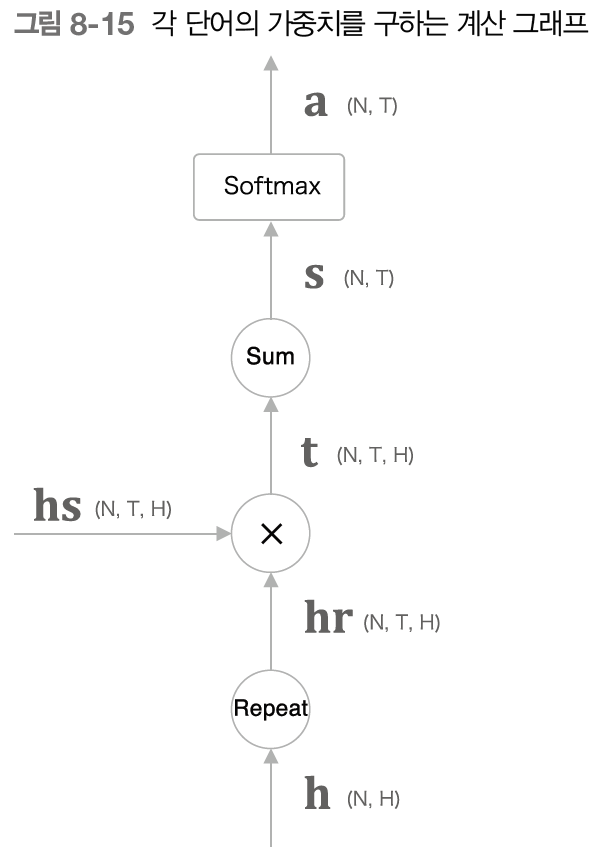

계산그래프는 위의 그림처럼 구성되어있음.
Repeat노드, 원소별 곱을 뜻하는 x노드, Sum노드, Softmax계층으로 구성
>이 계산 그래프가 표현하는 처리는 AttentionWeight클래스로 구현

In [5]:
import sys
sys.path.append('..')
from common.np import *  # NumPy 임포트
from common.layers import Softmax  # Softmax 레이어 임포트

class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []  # 학습하는 매개변수가 없음
        self.softmax = Softmax()  # Softmax 레이어 초기화
        self.cache = None  # 순전파 시 사용되는 중간 결과 저장
        
    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H).repeat(T, axis=1)  # 현재 시점의 은닉 상태를 적절한 형상으로 변환
        t = hs * hr  # 각 시계열 데이터의 현재 시점의 은닉 상태와의 원소별 곱셈
        s = np.sum(t, axis=2)  # 각 시계열 데이터에 대한 가중 합 계산
        a = self.softmax.forward(s)  # Softmax 레이어를 통해 각 시계열 데이터에 대한 확률 분포 계산
        
        self.cache = (hs, hr)  # 순전파 계산에 사용된 값 저장
        return a
    
    def backward(self, da):
        hs, hr = self.cache  # 순전파 때 계산했던 값 로드
        N, T, H = hs.shape
        
        ds = self.softmax.backward(da)  # Softmax 레이어의 역전파를 통해 출력에 대한 미분값 계산
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)  # 각 시계열 데이터에 대한 미분값 계산
        dhs = dt * hr  # hs에 대한 미분값 계산
        dhr = dt * hs  # hr에 대한 미분값 계산
        dh = np.sum(dhr, axis=1)  # h에 대한 미분값 계산
        
        return dhs, dh


**㉢Decoder 개선**

지금까지의 Decoder의 개선안으로 Attetion Weight계층과 Weight Sum계층을 구현하였다.
이 두 계층을 하나로 결합을 한다.

1.Attetion Weight계층은 Encoder가 출력하는 각 단어의 벡터hs에 주목하여 해당 단어의 가중치 a를 구한다.

2.Weight Sum계층은 a와 hs의 가중합을 구하고 그 결과를 맥락벡터 c로 출력한다.

이 일련의 계산을 수행하는 계층을 Attention계층이라고 한다.

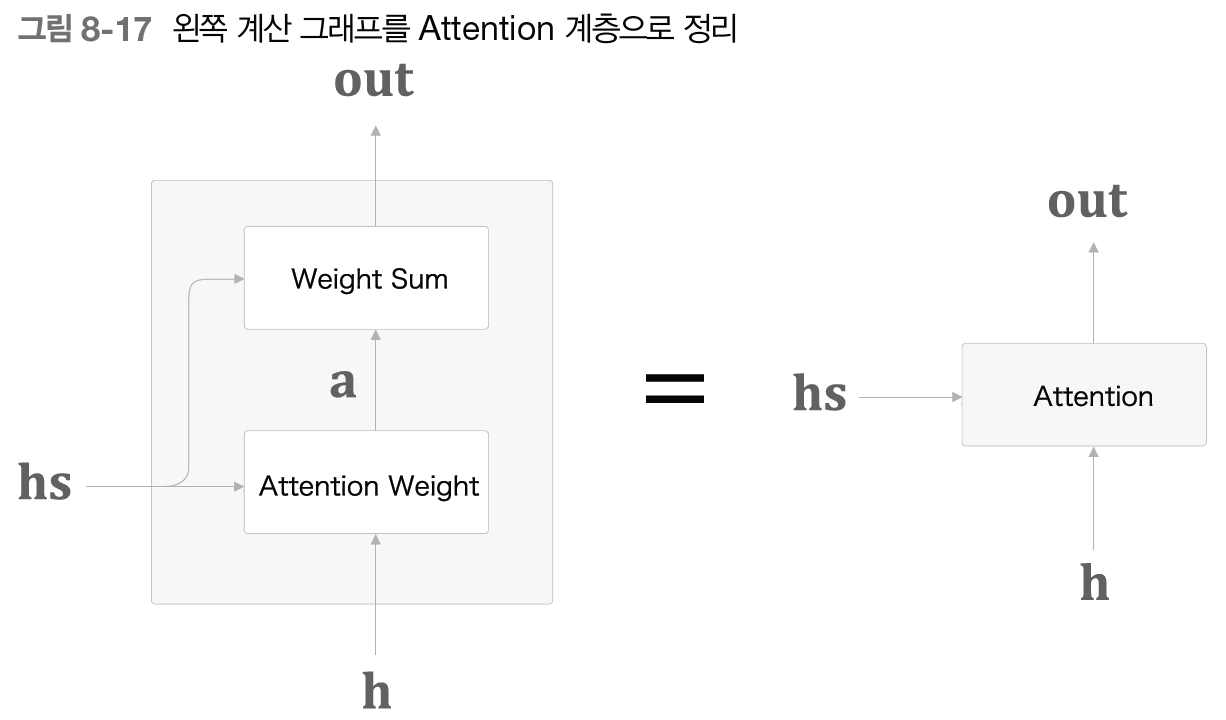

Encodr가 건네주는 정보 hs에서 중요한 원소에 주목하여 이를 바탕으로 맥락 벡터를 구해 위쪽 계층으로 전파.

h: Decoder의 LSTM계층이 출력한 은닉상태
hs: Encoder가 출력하는 각 단어에 대한 벡터
a: 가중치 벡터
c: 맥락 벡터

In [6]:
class Attention:
    def __init__(self):
        self.params, self.grads = [], []  # 학습하는 매개변수가 없음
        self.attention_weight_layer = AttentionWeight()  # AttentionWeight 계층 초기화
        self.weight_sum_layer = WeightSum()  # WeightSum 계층 초기화
        self.attention_weight = None  # 각 단어의 가중치를 저장하기 위한 변수
        
    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)  # AttentionWeight 계층에 의한 순전파 수행
        out = self.weight_sum_layer.forward(hs, a)  # WeightSum 계층에 의한 순전파 수행

        # 각 단어의 가중치를 나중에 참조하도록 attention_weight 변수에 저장
        self.attention_weight = a
        return out
    
    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)  # WeightSum 계층에 의한 역전파 수행

        # AttentionWeight 계층에 의한 역전파 수행
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1  # WeightSum 계층과 AttentionWeight 계층의 역전파 결과를 합산
        return dhs, dh


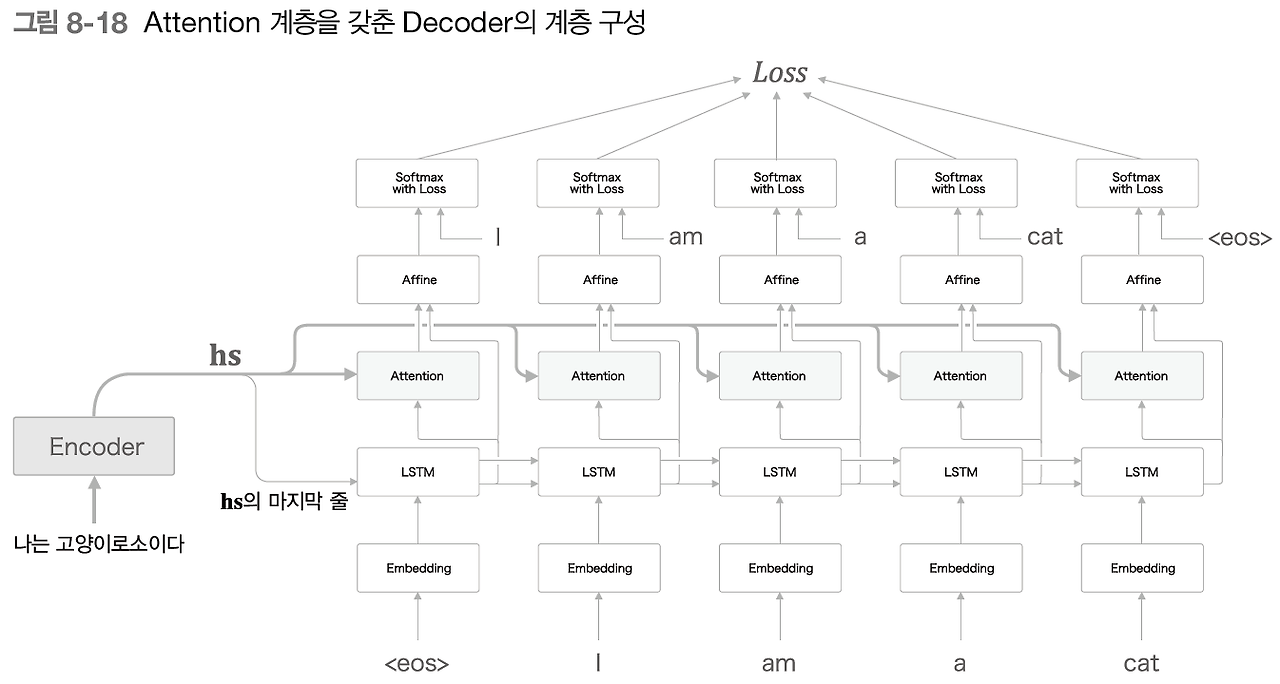
Attention계층을 LSTM계층과 Affine계층에 삽입

각 시각의 Attention계층에는 Encoder의 출력인 hs가 입력.
LSTM계층의 은닉 상태 벡터를 Affine계층에 입력.

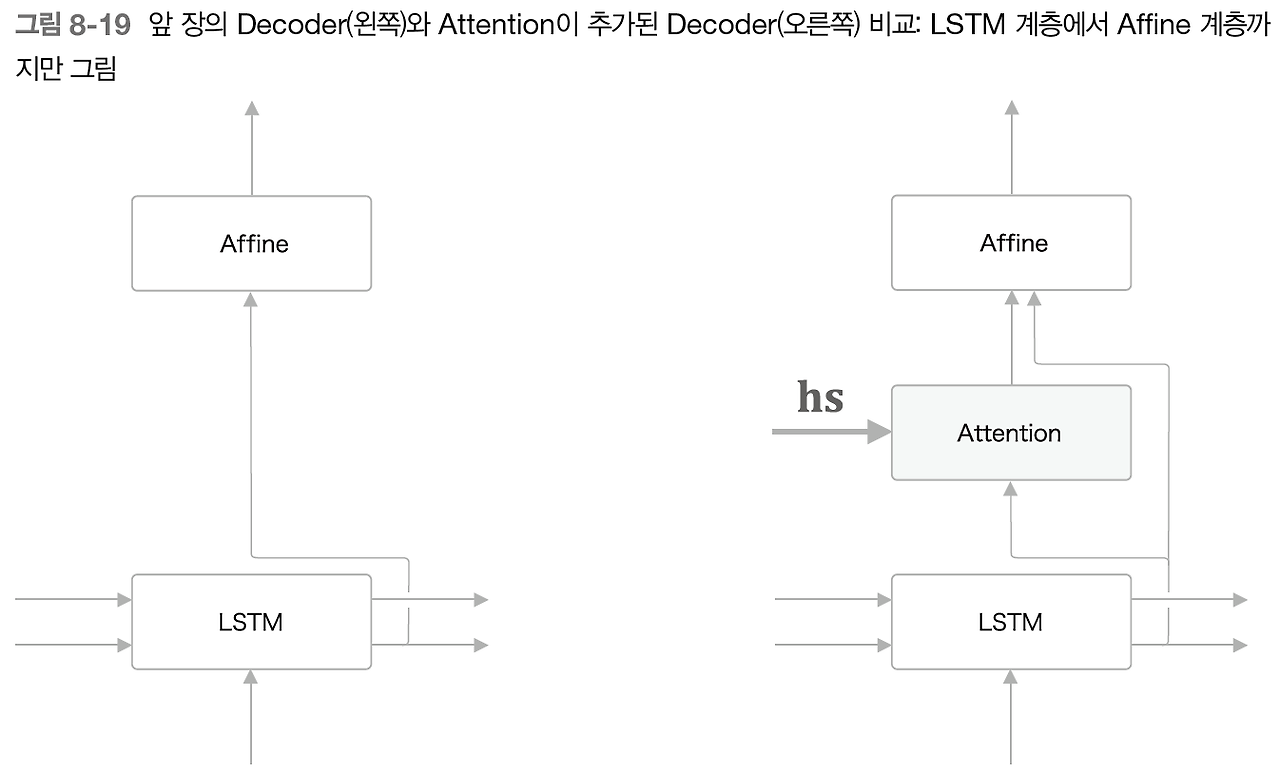

Decoder에 어텐션 정보를 '추가'하여 Affine계층에는 기존처럼 LSTM계층의 은닉 상태 벡터를 주고 추가적으로 Attention계층의 맥락 벡터까지 입력

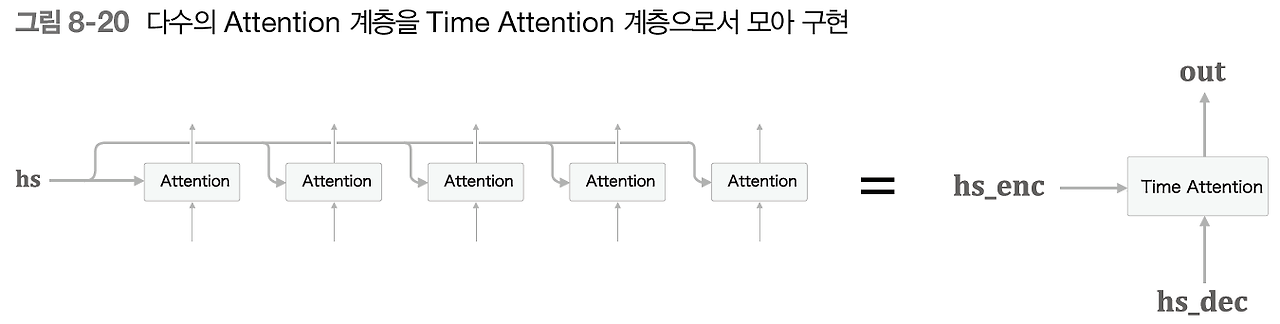
시계열 방향으로 펼쳐진 [그림8-18] 다수의 Attention계층을 Time Attention계층으로 모아 구현.

In [7]:
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []  # 학습하는 매개변수가 없음
        self.layers = None  # Attention 계층을 담을 리스트
        self.attention_weights = None  # 각 Attention 계층에서 계산된 가중치를 담을 리스트
        
    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape  # 디코더의 형상 정보를 획득
        out = np.empty_like(hs_dec)  # 디코더의 출력을 저장할 배열 생성
        self.layers = []  # 사용된 Attention 계층을 저장할 리스트 초기화
        self.attention_weights = []  # 각 Attention 계층에서 계산된 가중치를 저장할 리스트 초기화
        
        for t in range(T):  # 디코더의 시간 방향으로 반복
            layer = Attention()  # Attention 계층 생성

            # 해당 시점의 Attention 계층을 사용하여 출력 계산
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:, t, :])
            self.layers.append(layer)  # 사용된 Attention 계층을 리스트에 추가
            
            # 해당 시점의 Attention 계층에서 계산된 가중치를 리스트에 추가
            self.attention_weights.append(layer.attention_weight)
        
        return out
    
    def backward(self, dout):
        N, T, H = dout.shape  # 출력의 형상 정보를 획득
        dhs_enc = 0  # 인코더의 역전파 결과 초기화
        dhs_dec = np.empty_like(dout)  # 디코더의 역전파 결과를 저장할 배열 생성
        
        for t in range(T):  # 디코더의 시간 방향으로 역순으로 반복
            layer = self.layers[t]  # 해당 시점의 Attention 계층을 가져옴
            dhs, dh = layer.backward(dout[:, t, :])  # 해당 시점의 Attention 계층에 대한 역전파 수행
            dhs_enc += dhs  # 인코더의 역전파 결과 누적
            dhs_dec[:, t, :] = dh  # 디코더의 역전파 결과 저장
        
        return dhs_enc, dhs_dec


# 8.2 어텐션을 갖춘 seq2seq 구현

AttentionEncoder, AttentionDecoder, AttentionSeq2sq 구현

## 8.2.1 Encoder구현

In [8]:
import sys
sys.path.append('..')
from common.time_layers import*
from ch07.seq2seq import Encoder, Seq2seq
from ch08.attention_layer import TimeAttention
class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)  # Embedding 계층을 통해 입력을 단어 벡터로 변환

        # LSTM 계층을 통해 시계열 데이터를 처리하여 은닉 상태를 반환
        hs = self.lstm.forward(xs)
        return hs  # 시계열 방향으로 펼쳐진 은닉 상태를 반환

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)  # LSTM 계층에 대한 역전파 수행
        dout = self.embed.backward(dout)  # Embedding 계층에 대한 역전파 수행
        return dout


## 8.2.2 Decoder구현

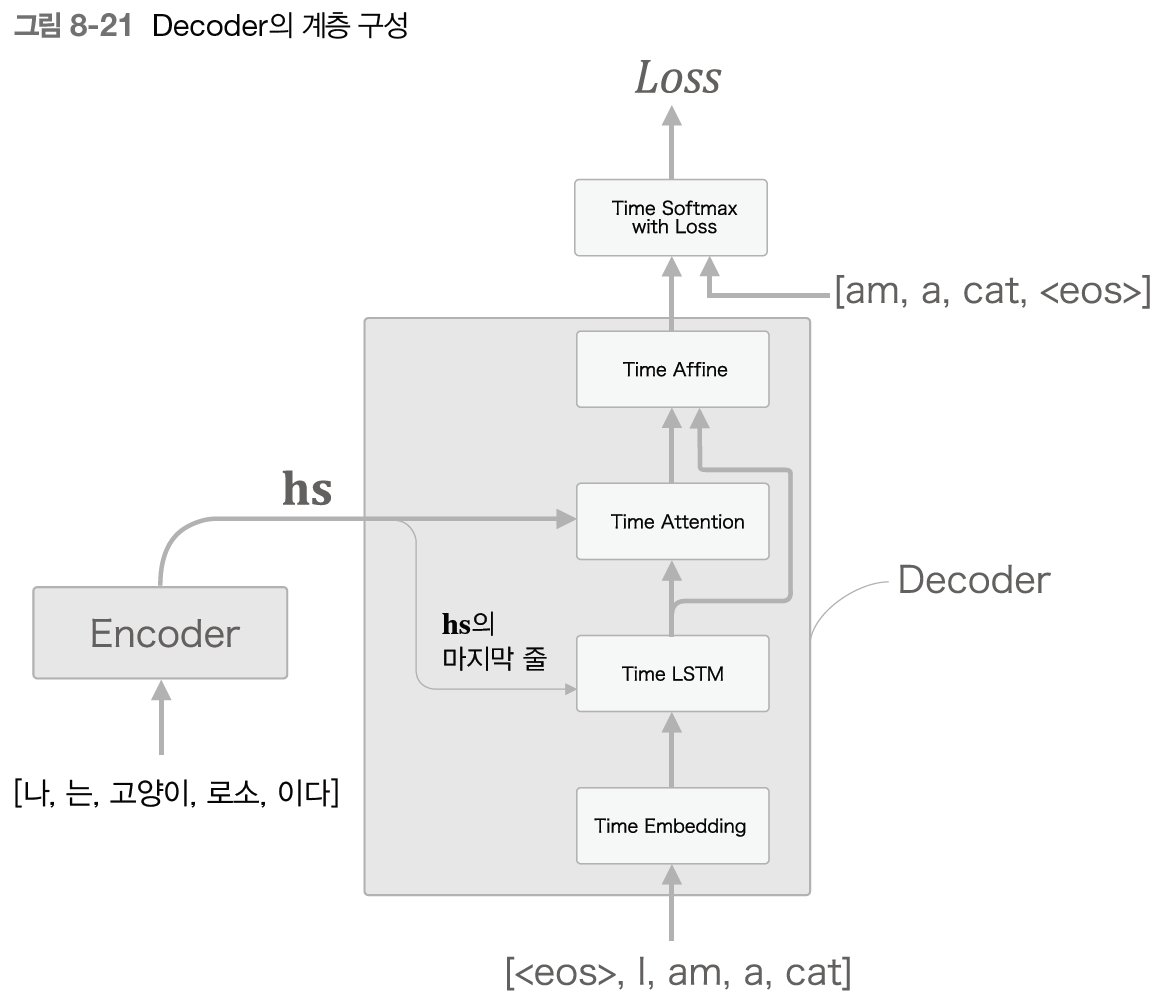

Time Softmax with Loss계층의 앞까지 Decoder로 구현

In [9]:
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size): # 어텐션 디코더 계층의 초기화
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        # 임베딩 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        # LSTM 가중치 초기화
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        # 어텐션 가중치 초기화
        # 기존 디코더와 달리 어텐션 계층을 추가하여 2*H로 변경
        affine_W = (rn(2 * H, V) / np.sqrt(2 * H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 계층 초기화
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()  # 어텐션 레이어 초기화
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]
        
        # 매개변수 및 기울기 초기화
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, enc_hs):
        h = enc_hs[:, -1]
        self.lstm.set_state(h)
        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)  # 어텐션 메커니즘 적용

        # Time Attention 계층의 출력과 LSTM 계층의 출력을 연결
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)
        
        return score
    
    def backward(self, dscore):
        # 합쳐진 출력을 역전파하기 위해 H=H2//2로 나눈다.
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:, :, :H], dout[:, :, H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        # Affine에 들어간 hs와 Attention에 들어간 hs를 더하여 lstm.backward()를 진행
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    # 새로운 단어열(혹은 문자열)을 생성하는 generate() 메서드
    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled


## 8.2.3 seq2seq 구현

In [10]:
from ch07.seq2seq import Encoder, Seq2seq

class AttentionSeq2seq(Seq2seq): # Seq2seq 클래스를 상속하여 AttentionSeq2seq 클래스 정의
    def __init__(self, vocab_size, wordvec_size, hidden_size):

        # vocab_size, wordvec_size, hidden_size를 args 변수에 할당
        agrs = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args) # AttentionEncoder 초기화
        self.decoder = AttentionDecoder(*args) # AttentionDecoder 초기화
        self.softmax = TimeSoftmaxWithLoss()  # Softmax Loss 계층 초기화
        
        # 매개변수와 기울기 초기화

        # Encoder와 Decoder의 매개변수 결합
        self.params = self.encoder.params + self.decoder.params

        # Encoder와 Decoder의 기울기 결합
        self.grads = self.encoder.grads + self.decoder.grads


# 8.3 어텐션 평가
날짜 형식을 변경하는 문제로 seq2seq의 효과를 확인

## 8.3.1 날짜 형식 변환 문제

"september 27,1994" → "1994-09-27" 으로 변환
 
날짜 형식변환으로 선정한 이유
1. 날짜 데이터에는 다양한 변형이 존재하여 변환 규칙이 나름 복잡
2. 날짜는 년,월,일의 대응관계가 존재하여 어텐션이 각각 원소에 올바르게 주목하는지 확인가능

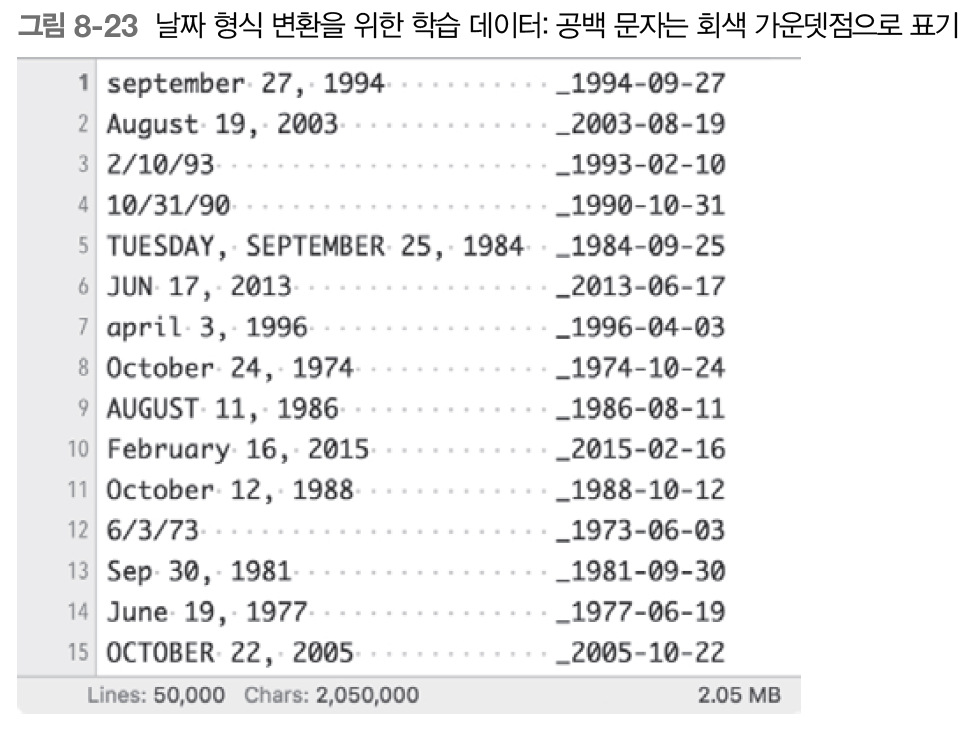
 입력과 출력의 구분문자는 '_'사용 & 출력의 문자 수가 일정하여 출력의 끝을 알리는 문자 사용안함.

## 8.3.2 어텐션을 갖춘 seq2seq의 학습

In [11]:
import sys
sys.path.append('..')
sys.path.append('../ch07')
import numpy as np
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from attention_seq2seq import AttentionSeq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')  # 'date.txt' 데이터셋 로드
char_to_id, id_to_char = sequence.get_vocab()  # 어휘 사전 생성

# 입력 문장 반전(Reverse)
# 입력 문장을 반전시켜 모델이 역순으로 입력을 받도록 함
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)  # 어휘 사전 크기
wordvec_size = 16  # 단어 벡터의 차원 수
hidden_size = 256  # 은닉 상태의 차원 수
batch_size = 128  # 미니배치 크기
max_epoch = 10  # 최대 에폭 수
max_grad = 5.0  # 기울기 클리핑을 위한 임계값

# 어텐션을 적용한 시퀀스-투-시퀀스 모델 생성
model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()  # Adam 옵티마이저 생성
trainer = Trainer(model, optimizer)  # 훈련을 위한 Trainer 객체 생성

# 에폭마다 테스트 데이터를 사용하여 정답률 측정
acc_list = []  # 정확도 저장을 위한 리스트 초기화
for epoch in range(max_epoch):
    # 모델 학습
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)
    
    # 정답률 측정
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]  # 테스트용 데이터 선택
        verbose = i < 10  # 상세한 출력 여부 결정
        
        # 평가 수행
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse=True)
    
    acc = float(correct_num) / len(x_test)  # 정확도 계산
    acc_list.append(acc)  # 정확도 리스트에 추가
    print('val acc %.3f%%' % (acc * 100))  # 정확도 출력
    
model.save_params()  # 학습된 모델 파라미터 저장

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 13[s] | 손실 3.09
| 에폭 1 |  반복 41 / 351 | 시간 26[s] | 손실 1.90


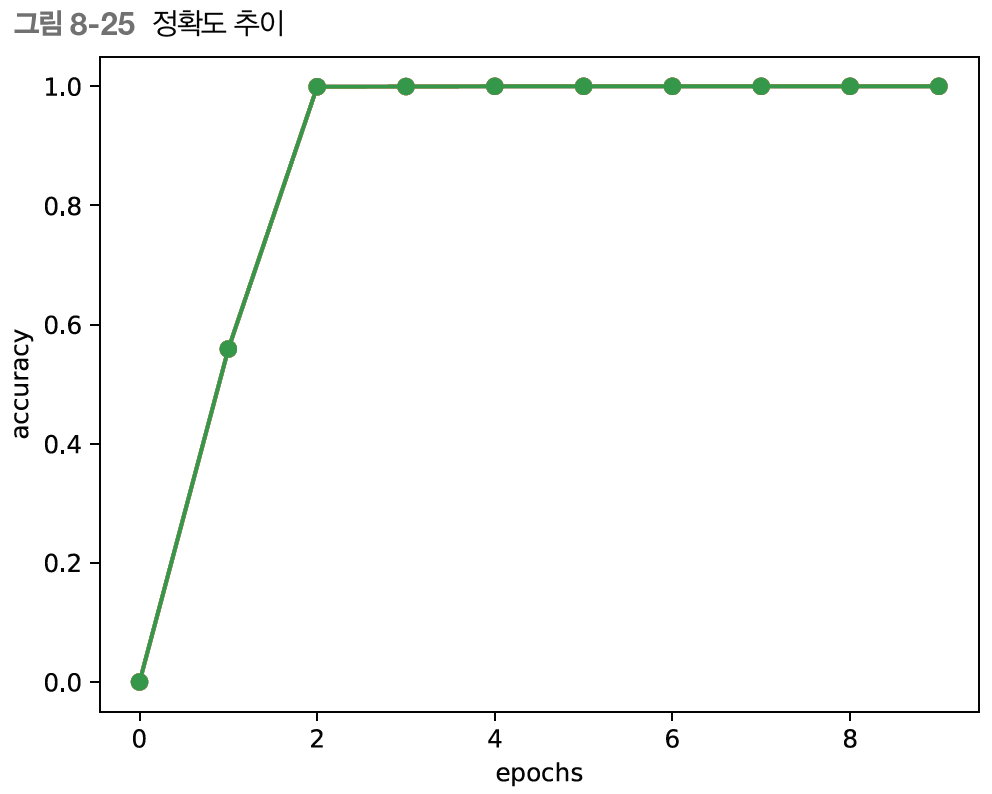

2에폭째에는 거의 모든 문제를 푼다.

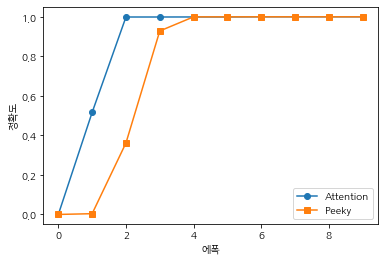

모델 peeky와 비교하였을때 학습 속도가 확실히 Attention이 우세할 뿐만 아니라 정확도 측면에서도 Attention이 유리하다.

#8.3.3 어텐션 시각화

시각화로 Attention이 어느 원소에 주의를 기울이는지를 볼 수 있다.
입력문장과 출력문장의 단어 대응관계를 2차원 맵으로 그릴 수 있다.
학습이 끝난 AttentionSeq2seq로 날짜 변환을 수행할 때의 어텐션 가중치를 시각화
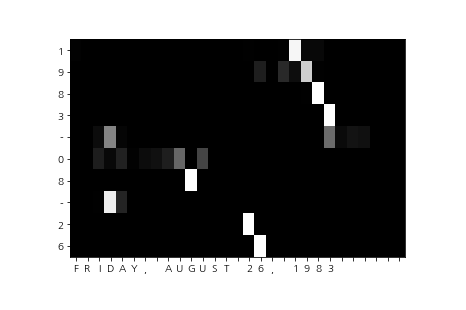

세로축(출력)의 "1983"과 "26"이 가로축(입력)의 "1983"과 "26"에 대응하고 있으며 "08"에 입력문장의 "AUGUST"가 대응 [각 맵의 원소는 밝을수록 값이 크다]

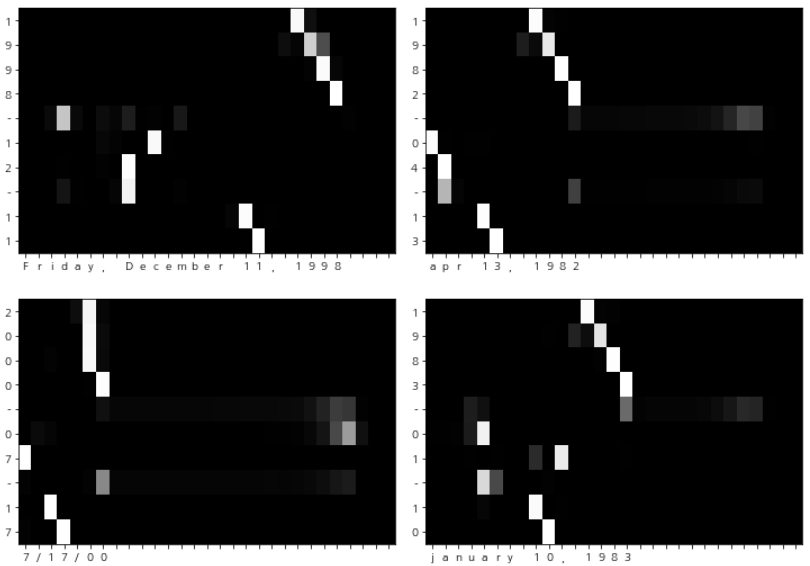

다른 예시들. 여기서도 년,월,일의 대응 관계를 명확히 간파한다.

**원래 신경망 내부에서는 어떠한 논리로 처리 되고 있는지를 인간이 이해할 수 없는것이 일반적.
하지만 어텐션은 '인간이 이해할 수 있는 구조나 의미'를 모델에 제공한다.
어텐션을 사용함으로써 모델의 처리 논리가 인간의 논리를 따르는지 판단 할 수 있다.**
